# Example Results

MLP architecture:
* 2 layers of 1000 ReLU units (i.e. 784 -> 1000 -> 1000 -> 10)
* initialize weights with random samples from Normal(0,1)
* adam optimization algorithm
* 50 epochs

Experiment Grid:
* baseline/batchnorm/layernorm
* batchsizes = [4,128]
* seeds = [1]

Goal of exercise: compare baseline, batchnorm, and layernorm

In [133]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn

import numpy as np
import h5py
import os

Populating the interactive namespace from numpy and matplotlib


/usr/local/pkg/python/2.7/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm', 'colors', 'plot', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Load results

See `example.py` for experiment launch:

In [134]:
def loadDataHDF5(data):
    if isinstance(data,h5py.File) or isinstance(data,h5py.Group):
        return {k:loadDataHDF5(v) for k,v in data.iteritems()}
    elif isinstance(data,h5py.Dataset):
        return data.value
    else:
        print 'unhandled datatype: %s' % type(data)

def loadHDF5(filepath):
    with h5py.File(filepath,'r') as f:
        return loadDataHDF5(f)

In [146]:
rootdir = 'output/example-mnist'
batchsizes = [5,100]
normalizations = [None,'batchnorm','layernorm']
seeds = range(1,2)

nonlinearity = 'sigmoid'
dim_hidden = 1000
numepochs = 50

#template filename
template = 'MLP_lr-{lr}-dh-{dim_hidden}-nc-10-l-2-nl-{nonlinearity}-opt-adam-bs-{bs}-ep-{numepochs}-idrop-1_0000e-01-reg-l2-rv-{rv}-rspec-_-bn-{bn}-ln-{ln}-seed-{seed}-uid--final.h5'

experiments = [(norm,bs,seed) for norm in normalizations for bs in batchsizes for seed in seeds]
results = {}
for vals in experiments:
    (norm,bs,seed) = vals
    lr = 0.01
    l2 = 0
    bn = False
    ln = False
    if norm=='batchnorm':
        bn=True
    if norm=='layernorm':
        ln=True
    filename = template.format(bs=bs,lr=('%0.4e'%lr).replace('.','_'),rv=('%0.4e'%l2).replace('.','_'),bn=bn,ln=ln,seed=seed,numepochs=numepochs,dim_hidden=dim_hidden,nonlinearity=nonlinearity)
    if filename in os.listdir(rootdir):
        if bn:
            key = 'batchnorm'
        elif ln:
            key = 'layernorm'
        else:
            key = 'baseline'
        key = (norm,bs)
        if key not in results:
            results[key] = {}
        results[key][seed] = loadHDF5(os.path.join(rootdir,filename))
    else:
        print 'could not find %s' % os.path.join(rootdir,filename)

# Concatenate results across seeds together

In [147]:
def concatenateSeeds(result,metric='valid_accuracy'):
    epochs = result.values()[0][metric][:,0]
    vals = []
    for seed,r in result.iteritems():
        vals.append(r[metric][:,1].reshape(1,-1))
    vals = np.concatenate(vals,axis=0)
    return epochs,vals

results_concat_seeds = {}
for k,r in results.iteritems():
    results_concat_seeds[k] = {}
    epochs, vals = concatenateSeeds(r,'valid_accuracy')
    results_concat_seeds[k]['valid_accuracy']={'epochs':epochs,'vals':vals}
    epochs, vals = concatenateSeeds(r,'train_crossentropy')
    results_concat_seeds[k]['train_crossentropy']={'epochs':epochs,'vals':vals}
results = results_concat_seeds


# Plot Metrics

In [148]:
def plot(metric,color=None):
    plt.plot(metric['epochs'],metric['vals'].mean(axis=0),label=label,color=color)
    mins = metric['vals'].min(axis=0)
    maxs = metric['vals'].max(axis=0)
    plt.fill_between(metric['epochs'],mins,maxs,color='b',alpha=0.1)
    

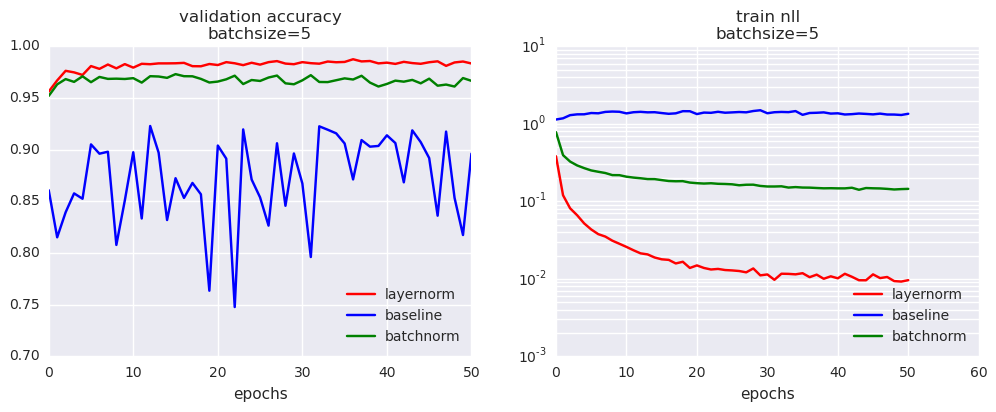

In [149]:
batchsize_filter=batchsizes[0]
colors={None:'b','batchnorm':'g','layernorm':'r'}
plt.figure(1,figsize=(12,4))

plt.subplot(1,2,1)
for k,r in results.iteritems():
    norm,bs = k
    if norm is None:
        label='baseline'
    else:
        label=norm
    if bs==batchsize_filter:
        plot(r['valid_accuracy'],color=colors[norm])
plt.legend(loc='lower right')
plt.title('validation accuracy\nbatchsize=%s'%batchsize_filter)
plt.xlabel('epochs')

plt.subplot(1,2,2)
for k,r in results.iteritems():
    norm,bs = k
    if norm is None:
        label='baseline'
    else:
        label=norm
    if bs==batchsize_filter:
        plot(r['train_crossentropy'],color=colors[norm])
plt.legend(loc='lower right')
plt.title('train nll\nbatchsize=%s'%batchsize_filter)
plt.xlabel('epochs')
plt.yscale('log')

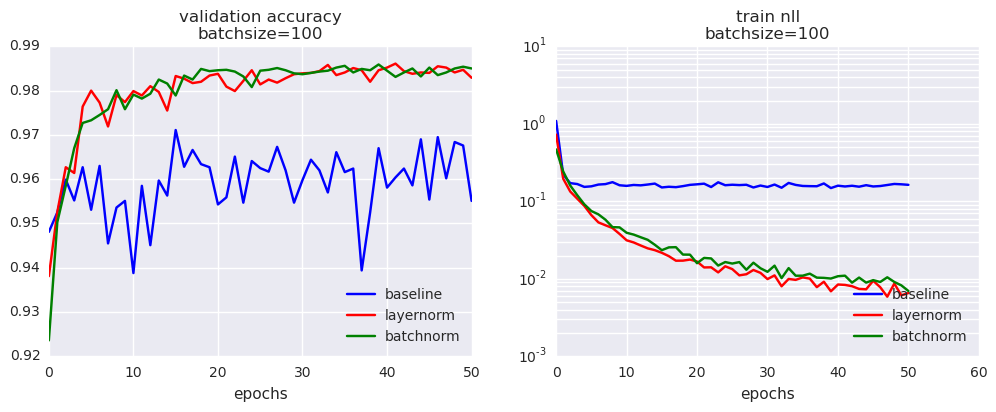

In [150]:
batchsize_filter=batchsizes[1]
colors={None:'b','batchnorm':'g','layernorm':'r'}
plt.figure(1,figsize=(12,4))

plt.subplot(1,2,1)
for k,r in results.iteritems():
    norm,bs = k
    if norm is None:
        label='baseline'
    else:
        label=norm
    if bs==batchsize_filter:
        plot(r['valid_accuracy'],color=colors[norm])
plt.legend(loc='lower right')
plt.title('validation accuracy\nbatchsize=%s'%batchsize_filter)
plt.xlabel('epochs')

plt.subplot(1,2,2)
for k,r in results.iteritems():
    norm,bs = k
    if norm is None:
        label='baseline'
    else:
        label=norm
    if bs==batchsize_filter:
        plot(r['train_crossentropy'],color=colors[norm])
plt.legend(loc='lower right')
plt.title('train nll\nbatchsize=%s'%batchsize_filter)
plt.xlabel('epochs')
plt.yscale('log')